In [ ]:
# install requirements
!pip install falkordb openai burr[graphviz] 

# Question & answer notebook

This notebook walks you through how to build a burr application that talks to falkorDB and openai to answer questions about UFC fights.

In [2]:
# import what we need
import json
from typing import Tuple

import openai
from burr.core import ApplicationBuilder, State, default, expr, Application
from burr.core.action import action
from burr.tracking import LocalTrackingClient
import uuid
from falkordb import FalkorDB
from graph_schema import graph_schema
import falkordb

## Helper functions
We first set up some helper functions that we'll use.

In [3]:
def schema_to_prompt(schema):
    """Prompt to help tell the LLM what is in the graph DB"""
    prompt = "The Knowledge graph contains nodes of the following types:\n"

    for node in schema['nodes']:
        lbl = node
        node = schema['nodes'][node]
        if len(node['attributes']) > 0:
            prompt += f"The {lbl} node type has the following set of attributes:\n"
            for attr in node['attributes']:
                t = node['attributes'][attr]['type']
                prompt += f"The {attr} attribute is of type {t}\n"
        else:
            prompt += f"The {node} node type has no attributes:\n"

    prompt += "In addition the Knowledge graph contains edge of the following types:\n"

    for edge in schema['edges']:
        rel = edge
        edge = schema['edges'][edge]
        if len(edge['attributes']) > 0:
            prompt += f"The {rel} edge type has the following set of attributes:\n"
            for attr in edge['attributes']:
                t = edge['attributes'][attr]['type']
                prompt += f"The {attr} attribute is of type {t}\n"
        else:
            prompt += f"The {rel} edge type has no attributes:\n"

        prompt += f"The {rel} edge connects the following entities:\n"
        for conn in edge['connects']:
            src = conn[0]
            dest = conn[1]
            prompt += f"{src} is connected via {rel} to {dest}, (:{src})-[:{rel}]->(:{dest})\n"

    return prompt

def set_inital_chat_history(schema_prompt: str) -> list[dict]:
    """Helper to set initial system message"""
    SYSTEM_MESSAGE = "You are a Cypher expert with access to a directed knowledge graph\n"
    SYSTEM_MESSAGE += schema_prompt
    SYSTEM_MESSAGE += ("Query the knowledge graph to extract relevant information to help you answer the users "
                       "questions, base your answer only on the context retrieved from the knowledge graph, "
                       "do not use preexisting knowledge.")
    SYSTEM_MESSAGE += ("For example to find out if two fighters had fought each other e.g. did Conor McGregor "
                       "every compete against Jose Aldo issue the following query: "
                       "MATCH (a:Fighter)-[]->(f:Fight)<-[]-(b:Fighter) WHERE a.Name = 'Conor McGregor' AND "
                       "b.Name = 'Jose Aldo' RETURN a, b\n")

    messages = [{"role": "system", "content": SYSTEM_MESSAGE}]
    return messages

## Tools
Here we describe the tool openAI will use & it's schema that will be passed to describe it.


In [4]:
def run_cypher_query(graph, query):
    """What executes a query against falkorDB"""
    try:
        results = graph.ro_query(query).result_set
    except:
        results = {"error": "Query failed please try a different variation of this query"}

    if len(results) == 0:
        results = {
            "error": "The query did not return any data, please make sure you're using the right edge "
                     "directions and you're following the correct graph schema"}

    return str(results)

# description
run_cypher_query_tool_description = {
    "type": "function",
    "function": {
        "name": "run_cypher_query",
        "description": "Runs a Cypher query against the knowledge graph",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": "Query to execute",
                },
            },
            "required": ["query"],
        },
    },
}

## Actions
Let's now define the actions that our application will make and what they read from & write to with respect to state.

We'll define four of them:

1. Human converse: This action will take the user's question and store it in the state.
2. AI create cypher query: This action will use the user's question to create a cypher query.
3. Tool call: This action will execute the cypher query and append the result to the chat history.
4. AI response: This action will take the result of the cypher query and create a response.

In [5]:
@action(
    reads=[],
    writes=["question", "chat_history"],
)
def human_converse(state: State, user_question: str) -> Tuple[dict, State]:
    """Human converse step -- make sure we get input, and store it as state."""
    new_state = state.update(question=user_question)
    new_state = new_state.append(chat_history={"role": "user", "content": user_question})
    return {"question": user_question}, new_state

In [6]:
@action(
    reads=["question", "chat_history"],
    writes=["chat_history", "tool_calls"],
)
def AI_create_cypher_query(state: State, client: openai.Client) -> tuple[dict, State]:
    """AI step to create the cypher query."""
    messages = state["chat_history"]
    # Call the function
    response = client.chat.completions.create(
        model="gpt-4-turbo-preview",
        messages=messages,
        tools=[run_cypher_query_tool_description],
        tool_choice="auto",
    )
    response_message = response.choices[0].message
    new_state = state.append(chat_history=response_message.to_dict())
    tool_calls = response_message.tool_calls
    if tool_calls:
        new_state = new_state.update(tool_calls=tool_calls)
    # if there are no tool calls -- it means we didn't know what to do
    return {"ai_response": response_message.content, "usage": response.usage.to_dict()}, new_state


In [7]:
@action(
    reads=["tool_calls", "chat_history"],
    writes=["tool_calls", "chat_history"],
)
def tool_call(state: State, graph: falkordb.Graph) -> Tuple[dict, State]:
    """Tool call step -- execute the query and append to chat history."""
    tool_calls = state.get("tool_calls", [])
    new_state = state
    result = {"tool_calls": []}
    for tool_call in tool_calls:
        function_name = tool_call.function.name
        assert (function_name == "run_cypher_query")
        function_args = json.loads(tool_call.function.arguments)
        function_response = run_cypher_query(graph, function_args.get("query"))
        new_state = new_state.append(chat_history=
            {
                "tool_call_id": tool_call.id,
                "role": "tool",
                "name": function_name,
                "content": function_response,
            }
        )
        result["tool_calls"].append({"tool_call_id": tool_call.id, "response": function_response})
    new_state = new_state.update(tool_calls=[])
    return result, new_state

In [8]:
@action(
    reads=["chat_history"],
    writes=["chat_history"],
)
def AI_generate_response(state: State, client: openai.Client) -> tuple[dict, State]:
    """AI step to generate the response given the current chat history."""
    messages = state["chat_history"]
    response = client.chat.completions.create(
        model="gpt-4-turbo-preview",
        messages=messages,
    )  # get a new response from the model where it can see the function response
    response_message = response.choices[0].message
    new_state = state.append(chat_history=response_message.to_dict())
    return {"ai_response": response_message.content,
            "usage": response.usage.to_dict()}, new_state


## Define the application
This is where we define our application now

In [9]:
# define our clients / connections / IDs
openai_client = openai.OpenAI()
db_client = FalkorDB(host='localhost', port=6379)
graph_name = "UFC"
application_run_id = str(uuid.uuid4())

In [10]:
# get the graph
graph = db_client.select_graph(graph_name)
# get schema
schema = graph_schema(graph)
# create a prompt from it
schema_prompt = schema_to_prompt(schema)
# set the initial chat history
base_messages = set_inital_chat_history(schema_prompt)

In [11]:
tracker = LocalTrackingClient("ufc-falkor")
# create graph
burr_application = (
    ApplicationBuilder()
    .with_actions(  # define the actions
        AI_create_cypher_query.bind(client=openai_client),
        tool_call.bind(graph=graph),
        AI_generate_response.bind(client=openai_client),
        human_converse
    )
    .with_transitions(  # define the edges between the actions based on state conditions
        ("human_converse", "AI_create_cypher_query", default),
        ("AI_create_cypher_query", "tool_call", expr("len(tool_calls)>0")),
        ("AI_create_cypher_query", "human_converse", default),
        ("tool_call", "AI_generate_response", default),
        ("AI_generate_response", "human_converse", default)
    )
    .with_identifiers(app_id=application_run_id)
    .with_state(  # initial state
       **{"chat_history": base_messages, "tool_calls": []},
    )
    .with_entrypoint("human_converse")
    .with_tracker(tracker)
    .build()
)

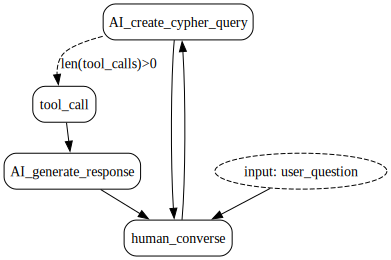

In [12]:
burr_application.visualize(include_conditions=True)

## Run the application
Here we show how to do a simple loop stopping before `human_converse` each time to get user input before running the graph again.


### Viewing a trace of the this application in the Burr UI
Note: you can view the logs of the conversation in the Burr UI. 

To see that, in another terminal do:

> burr

You'll then have the UI running on [http://localhost:7241/](http://localhost:7241/).

#### Using the Burr UI in google collab
To use the UI in google collab do the following:

1. Run this in a cell
```python
from google.colab import output
output.serve_kernel_port_as_window(7241)
```

2. Then start the burr UI:
```
!burr &
```
3. Click the link in (1) to open a new tab.

In [13]:
# run it
while True:
    # this will ask for input:
    question = input("What can I help you with?\n")
    if question == "exit":
        break
    current_action, _, current_state = burr_application.run(
        halt_before=["human_converse"],
        inputs={"user_question": question},
    )
    # we'll then see the AI response:
    print(f"AI: {current_state['chat_history'][-1]['content']}\n")
current_state

What can I help you with?
 Which fighter holds the fastest win?


AI: The fighter who holds the fastest win is Jorge Masvidal, achieving a victory in the first round within just 5 seconds.



What can I help you with?
 Who has a 50% win percentage?


AI: The list of fighters who have a 50% win percentage includes names like Joe Slick, Ken Stone, Kevin Jackson, Lorenz Larkin, and many others. This list comprises fighters who have an equal number of wins and losses within the records captured in the knowledge graph.



What can I help you with?
 List fighters who had a trilogy match


AI: It appears there was an error in the query execution process, which could be due to the structure of the query not matching the schema or data in the knowledge graph correctly. Without access to adjust and re-run with a more specific approach, it's challenging to provide the list of fighters who had a trilogy match based on the current data and schema. The concept was to identify pairs of fighters who have fought each other three times, but the data did not produce a straightforward list in response to the query as structured.



What can I help you with?
 Who has had three matches against the same opponent?


AI: The fighters who have had three matches against the same opponent include:

- Luke Rockhold vs. Michael Bisping
- Mauricio Rua vs. Forrest Griffin
- Georges St-Pierre vs. Matt Serra
- Tito Ortiz vs. Guy Mezger
- Jessica Andrade vs. Raquel Pennington
- Forrest Griffin vs. Tito Ortiz
- Jim Miller vs. Charles Oliveira
- Demetrious Johnson vs. Henry Cejudo
- Nikita Krylov vs. Ovince Saint Preux
- Junior Dos Santos vs. Cain Velasquez
- Uriah Hall vs. Gegard Mousasi
- TJ Dillashaw vs. Raphael Assuncao
- Frankie Edgar vs. Gray Maynard
- Dustin Poirier vs. Conor McGregor

...and many others. This list showcases fighters who have had a significant rivalry, resulting in at least three bouts against the same opponent.



What can I help you with?
 who has had the most wins with 0 losses?


AI: The fighter with the most wins and 0 losses is Khabib Nurmagomedov, with a total of 13 wins.



What can I help you with?
 exit


{'chat_history': [{'role': 'system', 'content': "You are a Cypher expert with access to a directed knowledge graph\nThe Knowledge graph contains nodes of the following types:\nThe Fighter node type has the following set of attributes:\nThe Name attribute is of type str\nThe Weight attribute is of type int\nThe DOB attribute is of type int\nThe SLpM attribute is of type float\nThe Str_Acc attribute is of type float\nThe SApM attribute is of type float\nThe Str_Def attribute is of type float\nThe TD_Avg attribute is of type float\nThe TD_Acc attribute is of type float\nThe TD_Def attribute is of type float\nThe Sub_Avg attribute is of type float\nThe Height attribute is of type float\nThe Stance attribute is of type str\nThe Reach attribute is of type float\nThe Referee node type has the following set of attributes:\nThe Name attribute is of type str\nThe Card node type has the following set of attributes:\nThe Date attribute is of type int\nThe Location attribute is of type str\nThe Fig

With Burr we can continue where we left off easily!

So why not run the conversation through some more?

In [14]:
# run it
while True:
    # this will ask for input:
    question = input("What can I help you with?\n")
    if question == "exit":
        break
    current_action, _, current_state = burr_application.run(
        halt_before=["human_converse"],
        inputs={"user_question": question},
    )
    # we'll then see the AI response:
    print(f"AI: {current_state['chat_history'][-1]['content']}\n")
current_state

What can I help you with?
 Who has Connor McGregor lost to the most?


AI: Conor McGregor has lost to Dustin Poirier the most, with a total of one loss.



What can I help you with?
 exit


{'chat_history': [{'role': 'system', 'content': "You are a Cypher expert with access to a directed knowledge graph\nThe Knowledge graph contains nodes of the following types:\nThe Fighter node type has the following set of attributes:\nThe Name attribute is of type str\nThe Weight attribute is of type int\nThe DOB attribute is of type int\nThe SLpM attribute is of type float\nThe Str_Acc attribute is of type float\nThe SApM attribute is of type float\nThe Str_Def attribute is of type float\nThe TD_Avg attribute is of type float\nThe TD_Acc attribute is of type float\nThe TD_Def attribute is of type float\nThe Sub_Avg attribute is of type float\nThe Height attribute is of type float\nThe Stance attribute is of type str\nThe Reach attribute is of type float\nThe Referee node type has the following set of attributes:\nThe Name attribute is of type str\nThe Card node type has the following set of attributes:\nThe Date attribute is of type int\nThe Location attribute is of type str\nThe Fig